# Load raster data via WMS

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
from websockets import connect
import pyarrow as pa
import logging
import urllib.parse
import json
import xarray as xr
import numpy as np

import geoengine as ge

In [2]:
logger = logging.getLogger('websockets')
# logger.setLevel(logging.DEBUG)
logger.setLevel(logging.ERROR)

## Initialize Geo Engine

In [3]:
ge.initialize("http://localhost:3030/api")

In [4]:
session = ge.get_session()
session

Server:              http://localhost:3030/api
Session Id:          18fec623-6600-41af-b82b-24ccf47cb9f9

## Define workflow of MODIS NDVI raster

In [5]:
workflow = ge.register_workflow({
                "type": "Raster",
                "operator": {
                    "type": "GdalSource",
                    "params": {
                        "data": {
                            "type": "internal",
                            "datasetId": "36574dc3-560a-4b09-9d22-d5945f2b8093"
                        }
                    }
                }
            })
workflow

c7b7c5c8-ee11-5418-bd1f-9e5889f6e04a

In [6]:
time_start = datetime.strptime('2014-04-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
time_end = datetime.strptime('2014-06-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")
bbox = ge.QueryRectangle(
    ge.BoundingBox2D(-180.0, -90.0, 180.0, 90.0),
    ge.TimeInterval(time_start, time_end),
    ge.SpatialResolution(0.1, 0.1),
)

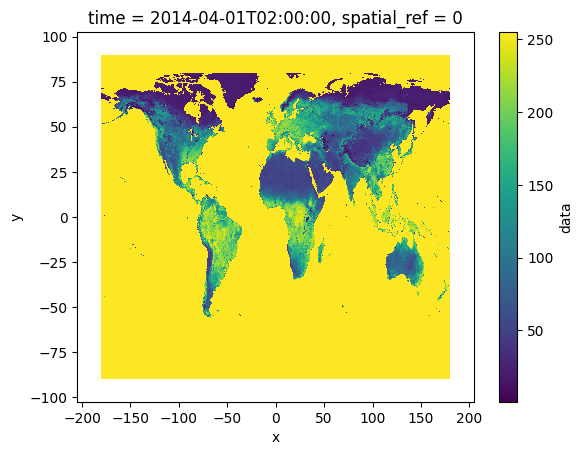

In [12]:
array = await workflow.raster_stream_into_xarray(bbox)
array.data.plot()

## Query raster via Websocket

In [8]:
'''

async def client(uri):
    async with connect(
        uri,
        extra_headers=ge.get_session().auth_header,
    ) as websocket:
        # await handler(websocket)

        global_tile = None

        while websocket.open:
            try:
                await websocket.send("NEXT")
                arrow_ipc = await websocket.recv()
                record_batch = read_arrow_ipc(arrow_ipc)
                tile = create_xarray(record_batch)

                # print(tile)

                print("LOCAL")
                tile.plot()
                plt.show()

                print("GLOBAL")
                global_tile = merge_tiles(global_tile, tile)
                global_tile.plot()
                plt.show()
            except Exception as e:
                print("An error occurred:")
                print(e)

        # if websocket.open:
        #     await websocket.close()

        await websocket.wait_closed()

def read_arrow_ipc(arrow_ipc):
    reader = pa.ipc.open_file(arrow_ipc)
    record_batch = reader.get_record_batch(0)
    return record_batch

def create_xarray(record_batch):
    metadata = record_batch.schema.metadata
    spatial_partition: ge.api.SpatialPartition2D = json.loads(metadata[b'spatialPartition'])
    x_size = int(metadata[b'xSize'])
    y_size = int(metadata[b'ySize'])
    arrow_array = record_batch.column(0)

    xmin = spatial_partition['upperLeftCoordinate']['x']
    xmax = spatial_partition['lowerRightCoordinate']['x']
    ymin = spatial_partition['lowerRightCoordinate']['y']
    ymax = spatial_partition['upperLeftCoordinate']['y']

    time = ge.TimeInterval.from_response(json.loads(metadata[b'time']))

    return xr.DataArray(
        arrow_array.to_numpy(zero_copy_only=False).reshape(x_size, y_size),
        dims=["y", "x"],
        coords={
            'x': np.linspace(xmin, xmax, x_size, endpoint=False),
            'y': np.linspace(ymax, ymin, y_size, endpoint=False),
            'time': time.start, # TODO: incorporate time end?
        },
    )

def merge_tiles(global_tile, tile):
    if global_tile is None:
        return tile

    try:
        # can be used as long as the coordinates are not yet in the dataset (e.g., as NaN)
        return xr.combine_by_coords(
            [global_tile, tile],
        )
    except:
        # can be used to fill in the coordinates that were previously NaN
        return global_tile.combine_first(tile)

ws_server_url = ge.get_session().server_url.replace("http", "ws")
url = f"{ws_server_url}/workflow/{workflow}/rasterStream?resultType=arrow&spatialBounds={bbox.bbox_str}&timeInterval={urllib.parse.quote(bbox.time_str)}&spatialResolution={bbox.spatial_resolution}"
print(url)
await client(url)

'''

'\n\nasync def client(uri):\n    async with connect(\n        uri,\n        extra_headers=ge.get_session().auth_header,\n    ) as websocket:\n        # await handler(websocket)\n\n        global_tile = None\n\n        while websocket.open:\n            try:\n                await websocket.send("NEXT")\n                arrow_ipc = await websocket.recv()\n                record_batch = read_arrow_ipc(arrow_ipc)\n                tile = create_xarray(record_batch)\n\n                # print(tile)\n\n                print("LOCAL")\n                tile.plot()\n                plt.show()\n\n                print("GLOBAL")\n                global_tile = merge_tiles(global_tile, tile)\n                global_tile.plot()\n                plt.show()\n            except Exception as e:\n                print("An error occurred:")\n                print(e)\n\n        # if websocket.open:\n        #     await websocket.close()\n\n        await websocket.wait_closed()\n\ndef read_arrow_ipc(arrow_ip

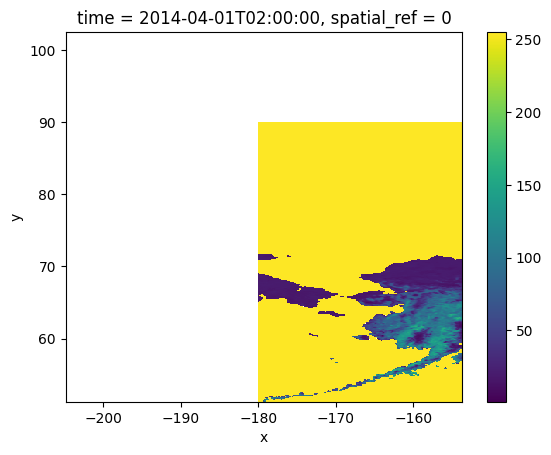

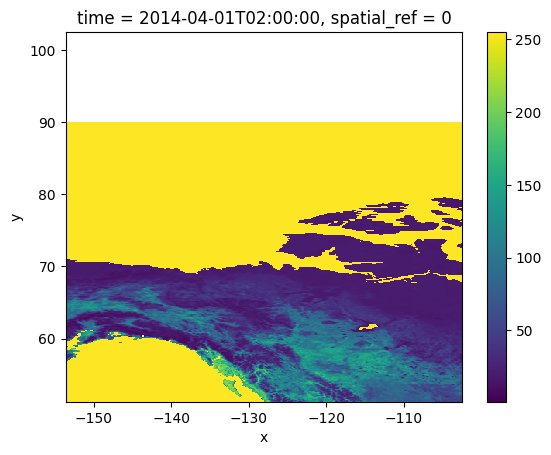

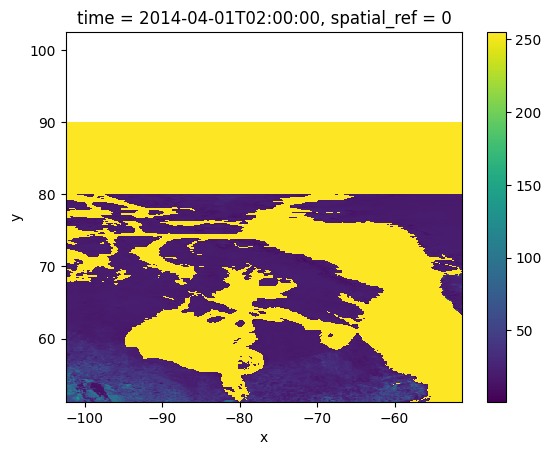

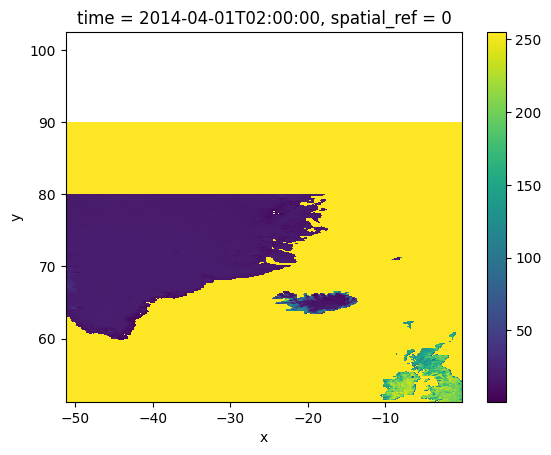

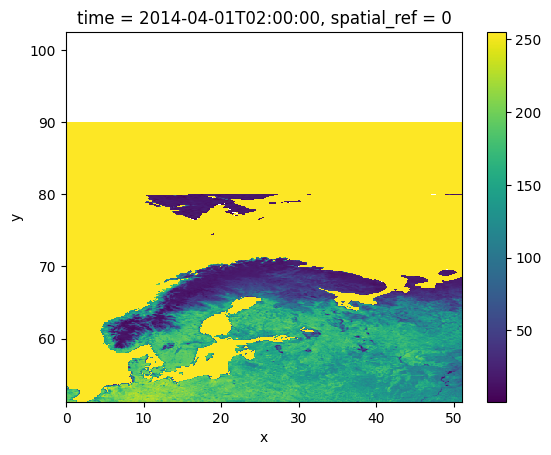

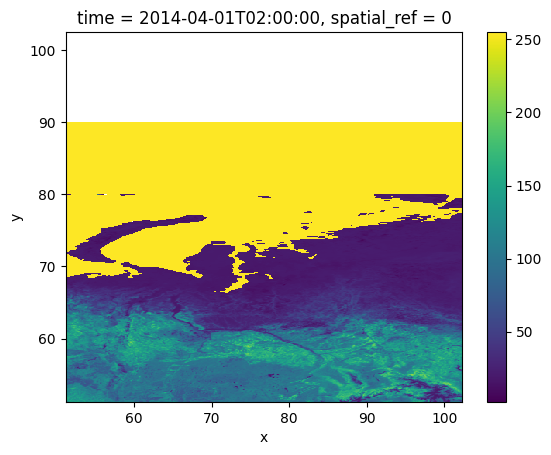

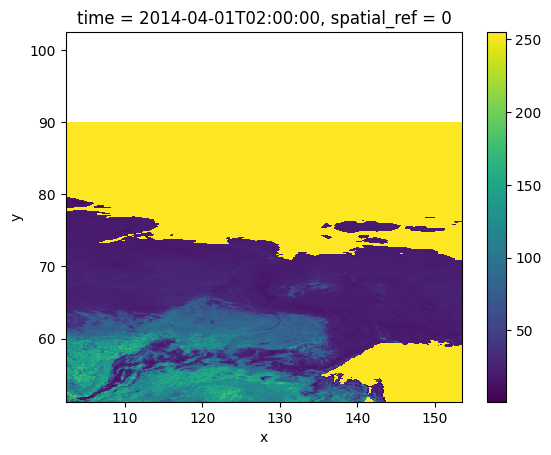

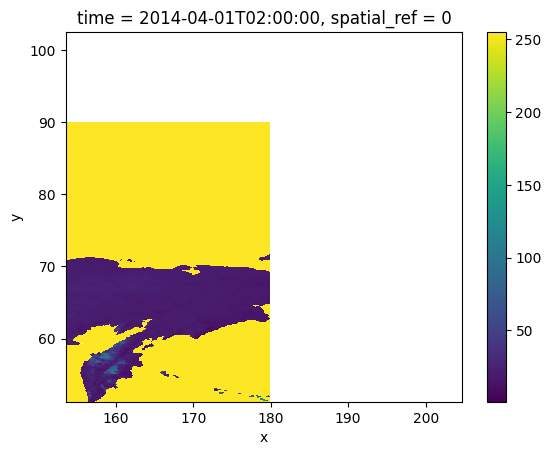

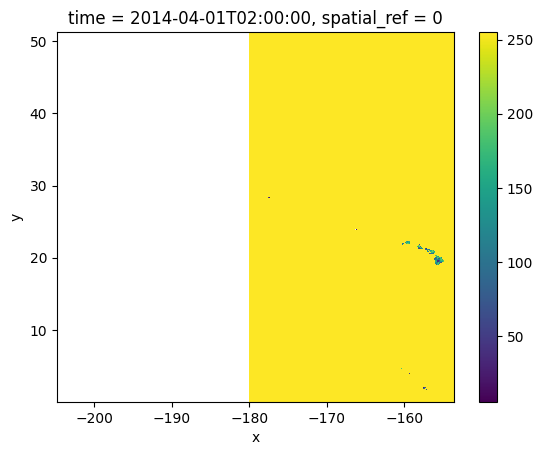

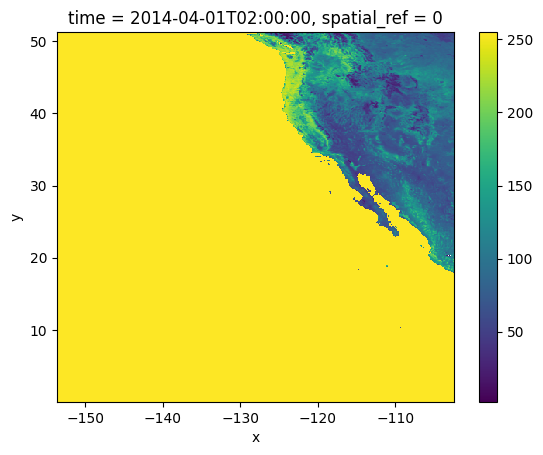

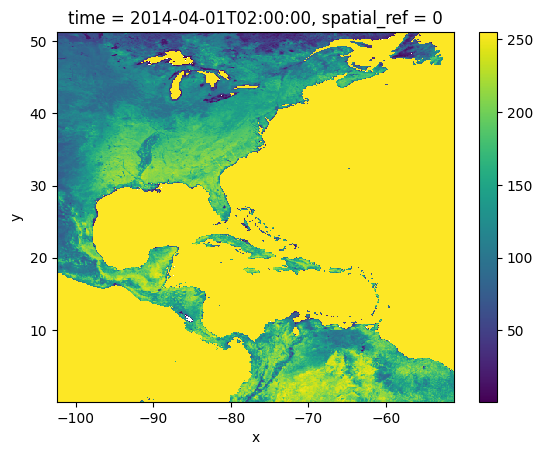

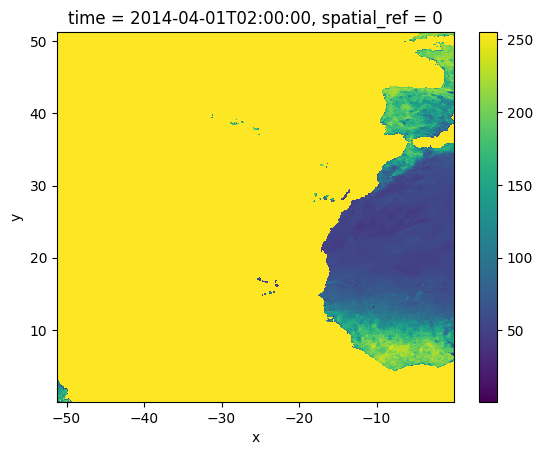

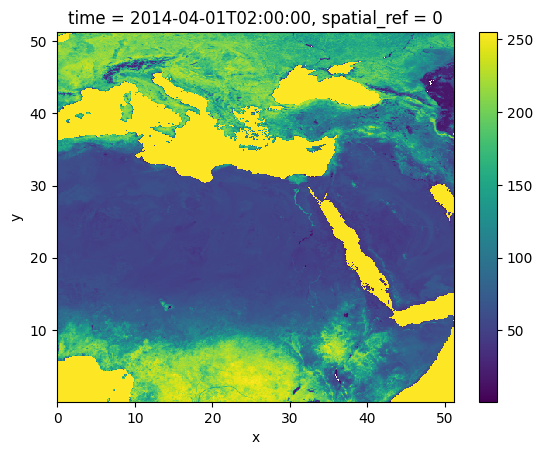

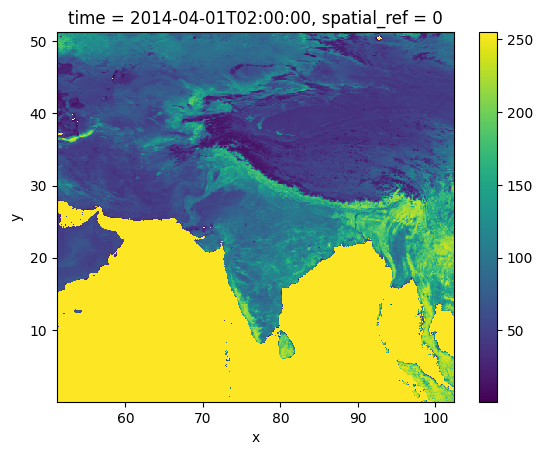

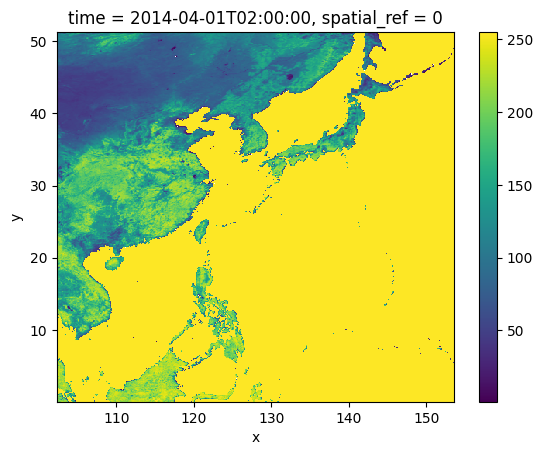

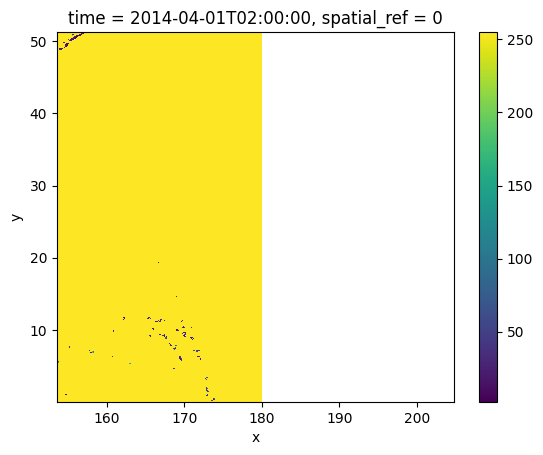

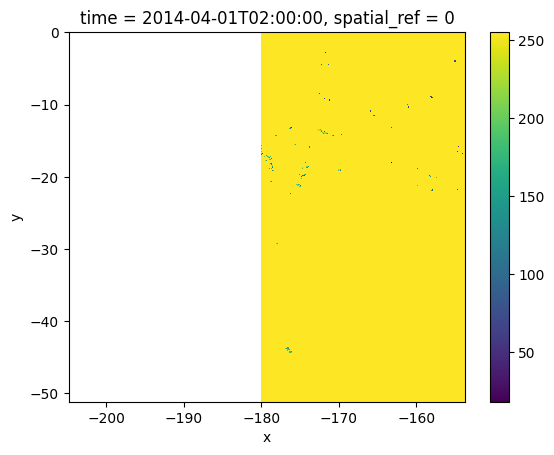

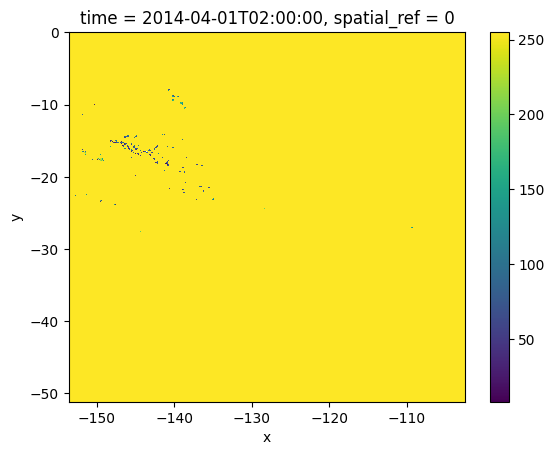

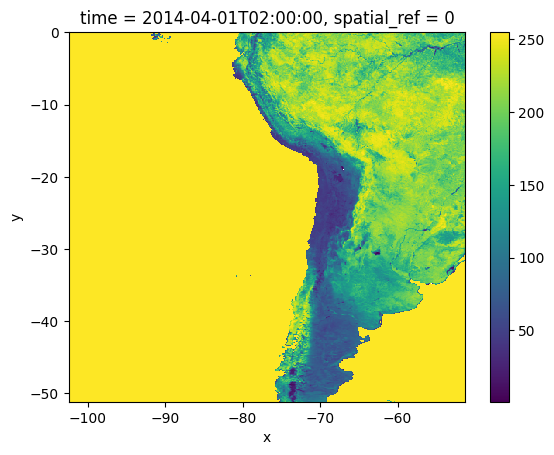

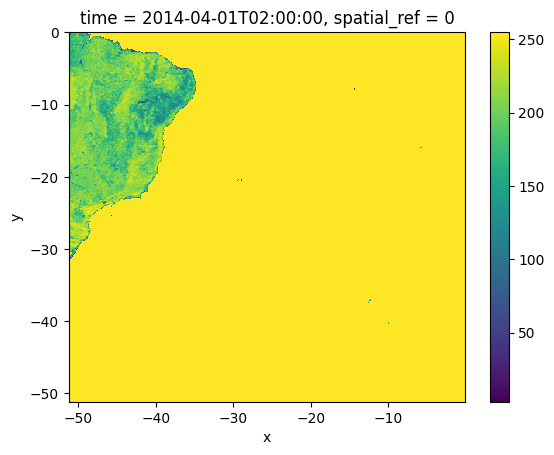

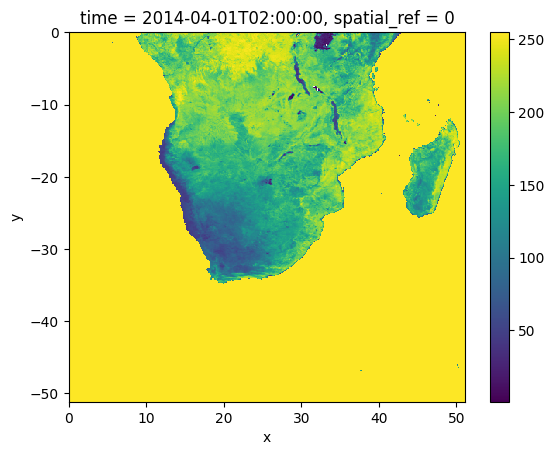

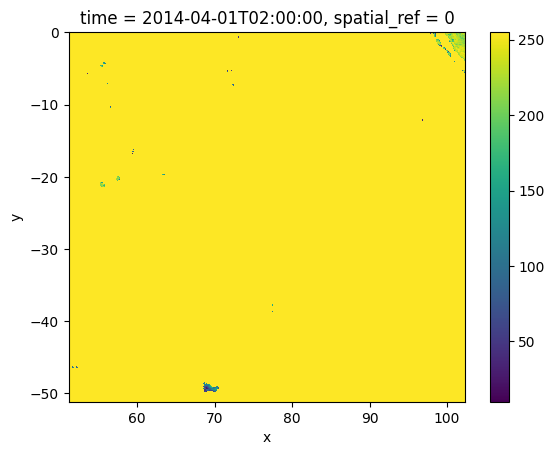

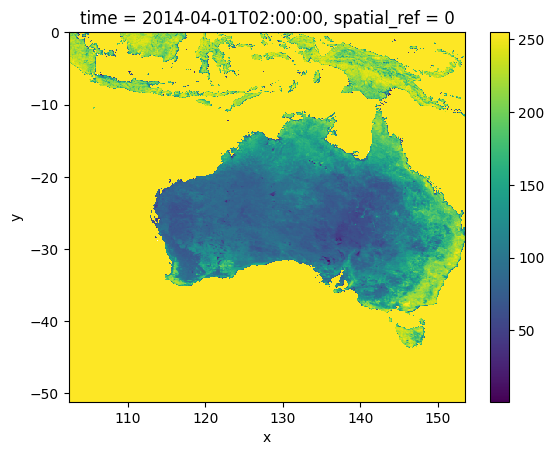

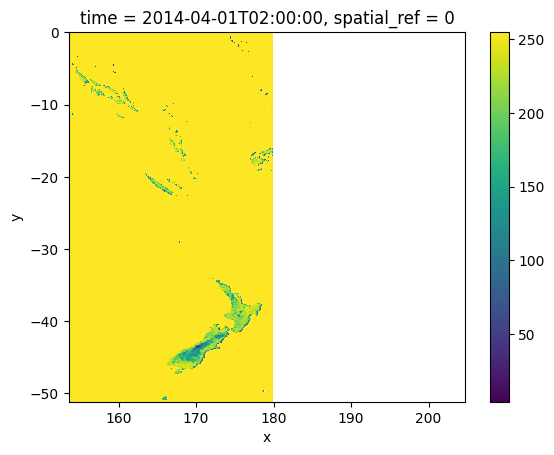

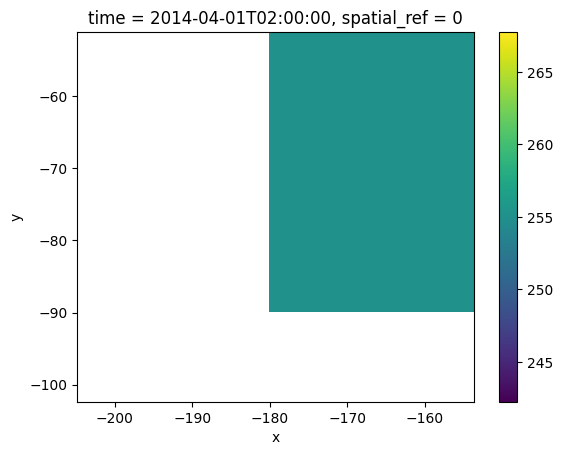

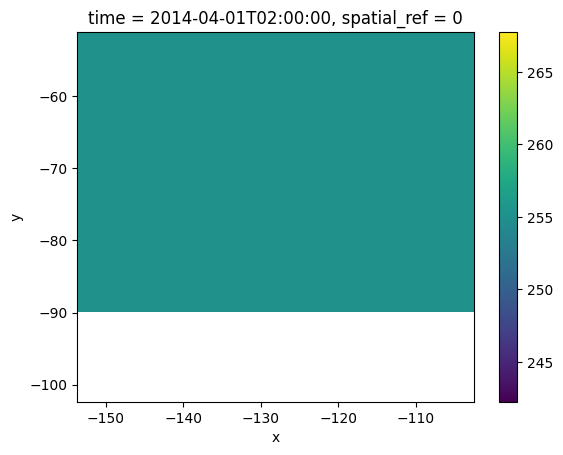

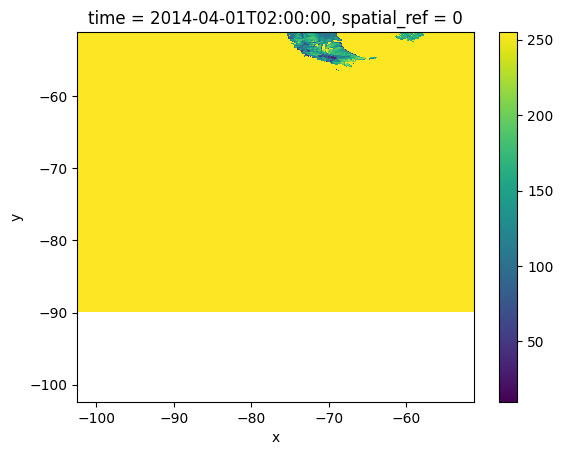

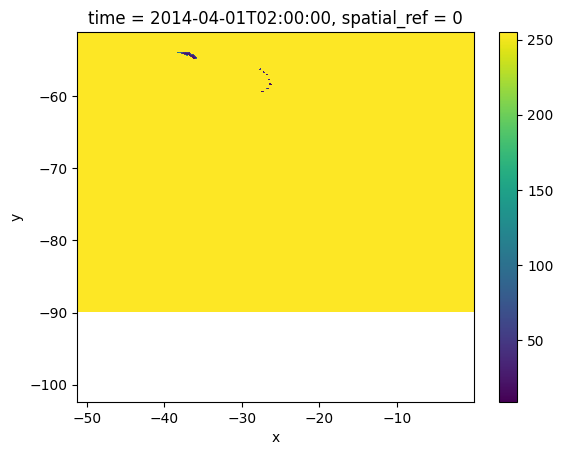

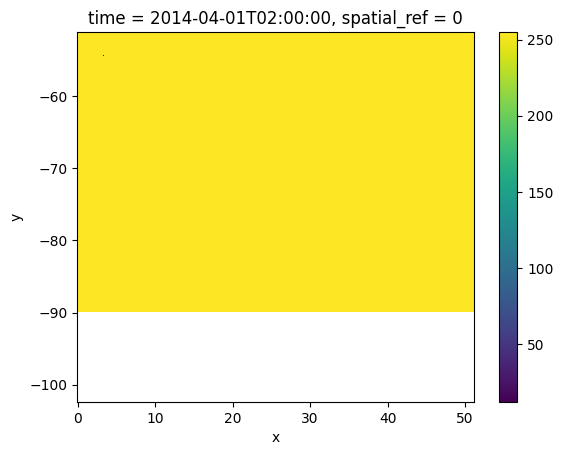

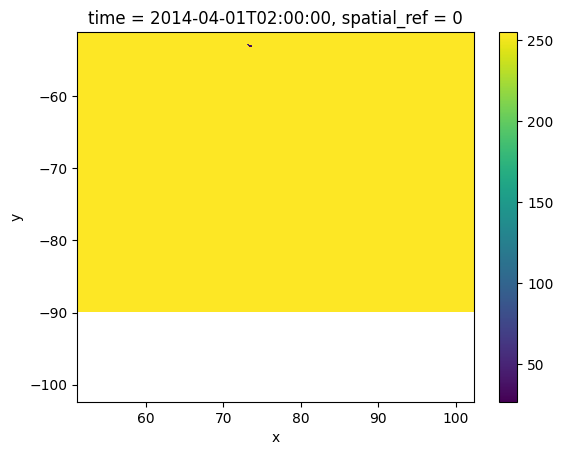

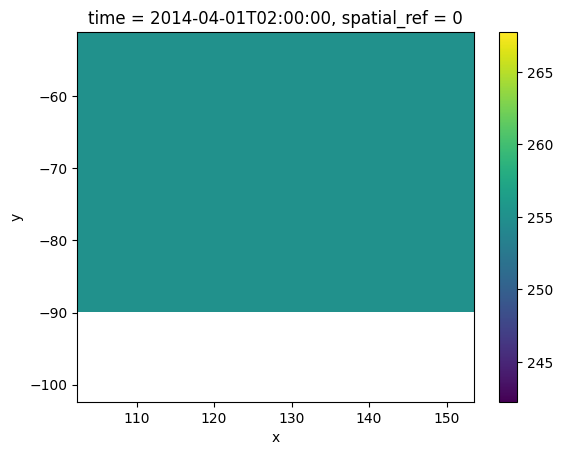

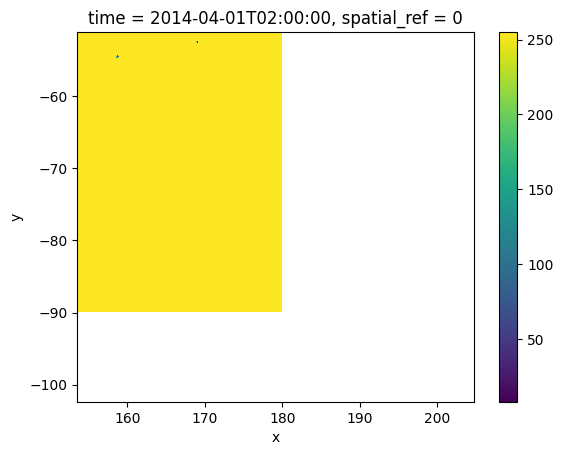

In [9]:
async for tile in workflow.raster_stream(bbox):
    # print(tile.rio.crs)
    tile.plot()
    plt.show()

In [10]:
type(tile)

xarray.core.dataarray.DataArray